In [1]:
import torch
import matplotlib.pyplot as plt
from common import *
import time
import copy
import gym

import xarray as xr
import numpy as np

import os
import matplotlib

from itertools import repeat

def do_rollout_from_state(env, policy, init_state, obs_std=.1, act_std=.1, num_steps=1000, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list

def do_push_rollout_from_state(env, policy, init_state, force, num_steps=2, render=False):
    torch.autograd.set_grad_enabled(False)
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []

    dtype = torch.float32
    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs += torch.randn(obs_size)*obs_std
        obs_list.append(obs.clone())
        
        x_list.append(env.unwrapped.sim.data.qpos[0])
        env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        
        act = policy(obs)
        act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act.numpy())
        
        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)
        
    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, x_list


def do_limit_rollout(trial_num):
    env.seed(trial_num)
    np.random.seed(trial_num)
    torch.manual_seed(trial_num)
#     obs, acts, rews, _ = do_rollout_from_state(env, iden_policy, iden_lstate, obs_std, act_std)
#     iden_obs = (obs - iden_policy.state_means)/(iden_policy.state_std)
    
    env.seed(trial_num)
    obs, acts, rews, _ = do_rollout_from_state(env, mdim_policy, mdim_lstate, obs_std, act_std)
    mdim_obs = (obs - mdim_policy.state_means)/(mdim_policy.state_std)
    
    
    return None, mdim_obs

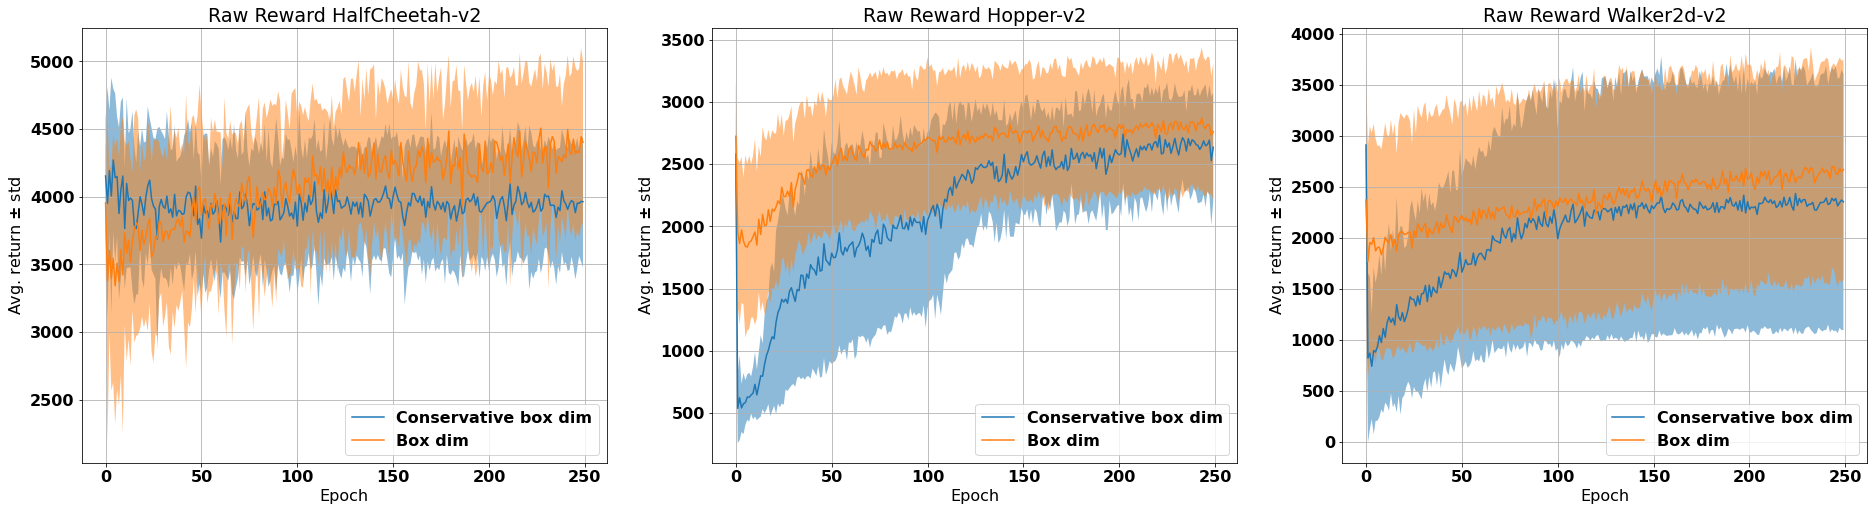

In [2]:
env_names = ["HalfCheetah-v2", "Hopper-v2", "Walker2d-v2"]
init_names = ["identity", "madodiv", "identity"]

font = {'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

fig, ax = plt.subplots(1, len(env_names), figsize=(32,8))

i = 0 
for env_name, init_name in zip(env_names, init_names):
    init_data = torch.load(f"./data17/{env_name}.xr")
    init_policy_dict = init_data.policy_dict
    
    data = torch.load(f"./data_mcshdim4/{env_name}.xr")
    policy_dict = data.policy_dict
    rews = data.rews#/data.post_rews
    exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
    num_seeds = len(policy_dict[exp_names[0]])

    means = rews.mean(dim="trial")
    stds = rews.std(dim="trial")

    #plt.subplots(1,1, figsize=(10,7))
    ax[i].plot(means.T)
    ax[i].legend(['Conservative box dim', 'Box dim'], loc='lower right')
    ci = stds

    for mean, c in zip(means, ci):
        ax[i].fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
        
    ax[i].set_title(f"Raw Reward {env_name}")
    ax[i].set_ylabel(r"Avg. return $\pm$ std")
    ax[i].set_xlabel(r"Epoch")
    ax[i].grid()
    i+=1
    
#     for exp_name in exp_names:  
#         plt.plot(rews.loc[exp_name].T[:,0:10])
#         plt.legend([i for i in range(10)])
#         plt.title(exp_name)
#         plt.figure()

In [15]:
#===============================
# env_name = "Walker2d-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,3,4,5,6]
# rollout_length = 1000
# lookback_length = 50

#===============================
# env_name = "HalfCheetah-v2"
# post_names = ['identity', 'mdim_div']

# def my_reset(env, point):
#     env.reset()
#     qpos = np.concatenate((np.array([0.0]), point[:8]))
#     qvel = point[8:]
#     env.unwrapped.set_state(qpos, qvel)
#     return env.unwrapped._get_obs()

# seeds = [0,1,2,3,4,5,6,7,8,9]
# rollout_length = 100
# lookback_length = 5

# def fail_cond(ob):
#     return not (-.25 < ob[1] < .25)

#===============================
env_name = "Hopper-v2"
post_names = ['madodiv', 'mdim_div']

def my_reset(env, point):
    env.reset()
    qpos = np.concatenate((np.array([0.0]), point[:5]))
    qvel = point[5:]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(ob):
    return not (-.25 < ob[1] < .25)

seeds = [0,1,2,3,4,5,6,7,8,9]
rollout_length = 3
lookback_length = 1
# ===============================


env = gym.make(env_name)
data = torch.load(f"./data17/{env_name}.xr")
init_policy_dict = data.policy_dict

data = torch.load(f"./data_mcshdim4/{env_name}.xr")
policy_dict = data.policy_dict
policy_dict['identity'] = init_policy_dict['identity']
policy_dict['madodiv'] = init_policy_dict['madodiv']

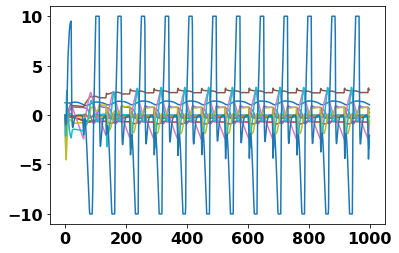

In [16]:
#plot a single trajectory
obs, acts, rews, _  = do_long_rollout(env, policy_dict['mdim_div'][2], ep_length=1000)
plt.plot(obs);

# Construct Mesh

In [17]:
seed = 2; delta = .0001; obs_std=0; act_std=0

iden_policy = policy_dict[post_names[0]][seed]
mdim_policy = policy_dict[post_names[1]][seed]

iden_mesh = BoxMesh(delta); iden_l = []
mdim_mesh = BoxMesh(delta); mdim_l = []

batch_size = 128

obs, acts, rews, _ = do_rollout(env,iden_policy)
iden_lstate  = obs[500]

obs, acts, rews, _ = do_rollout(env,mdim_policy)
mdim_lstate  = obs[500]

In [18]:
import time
start = time.time()

from torch.multiprocessing import Pool
with Pool() as pool:

    for i in range(0, 5):
        iden_mesh_list = []
        mdim_mesh_list = []
        for j, res in enumerate(pool.imap(do_limit_rollout, range(i*batch_size, i*batch_size+batch_size))):
            iden_obs, mdim_obs = res
            
#             for o in iden_obs:
#                 if o in iden_mesh:
#                     iden_mesh[o]+=1
#                 else:
#                     iden_mesh[o]=1

            for o in mdim_obs:
                if o in mdim_mesh:
                    mdim_mesh[o][1]+=1
                else:
                    mdim_mesh[o]=[len(mdim_mesh), 1]
                    
        iden_l.append(len(iden_mesh)); mdim_l.append(len(mdim_mesh))
        
        if i % 10 == 0:
            print(f"i; {i}, mdim: {len(mdim_mesh)}")
            #print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")
        
print(time.time() - start)

i; 0, mdim: 1039
21.015816688537598


Text(0, 0.5, 'mesh points')

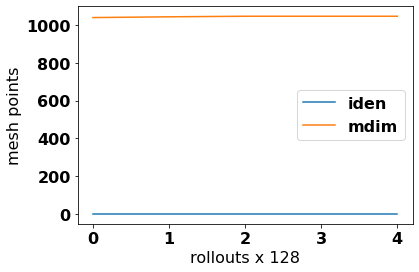

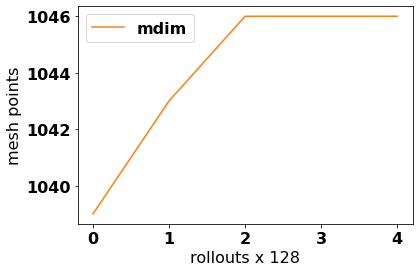

In [19]:
plt.plot(iden_l)
plt.plot(mdim_l)
plt.legend(['iden','mdim'])
plt.xlabel('rollouts x 128')
plt.ylabel('mesh points')

plt.figure()
plt.plot(mdim_l, color='tab:orange')
plt.legend(['mdim'])
plt.xlabel('rollouts x 128')
plt.ylabel('mesh points')

# Plot frequenecy of visitiation

In [20]:
vals = []
keys = []
for key in mdim_mesh.keys():
    vals.append(mdim_mesh[key])
    keys.append(key)
    
vals = np.array(vals)
keys = np.array(keys)

sort_idx = vals[:,1].argsort()

vals = vals[sort_idx]
keys = keys[sort_idx]

Text(0, 0.5, '# of states in box')

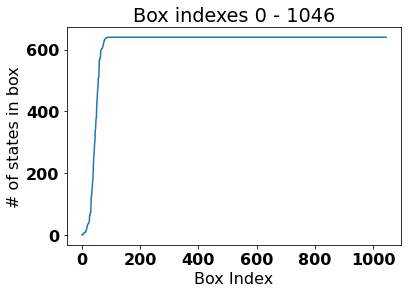

In [21]:
start = 0; stop=1
plt.plot(range(start, len(vals) - stop), vals[start:-stop,1])

plt.title(f'Box indexes {start} - {len(vals-stop)}')
plt.xlabel('Box Index')
plt.ylabel('# of states in box')

# Shrink mesh to frequently visited states

In [ ]:
total_sum = vals[:,1].sum()
orig_mesh_size = len(mdim_mesh)
sum_so_far = 0
i = 0
for val in vals[::-1]:
    sum_so_far += val[1]
    i+=1
    if sum_so_far / total_sum > .9:
        break
        
num_to_remove = len(vals) - i

print(f"{i/orig_mesh_size} % of the boxes make up {sum_so_far/total_sum} of visitied states")

for i in range(num_to_remove):
    del mdim_mesh[keys[i]]
    
for i,key in enumerate(mdim_mesh.keys()):
    mdim_mesh[key][0] = i
    
    
print(f"mesh now has {len(mdim_mesh)} states")

# Construct and Populate Transition Matrix

In [22]:
from scipy.sparse import lil_matrix
T = lil_matrix((len(mdim_mesh)+2, len(mdim_mesh)+2))

In [23]:
def do_explore_rollout(args):
    force, init_state, trial_num = args
    env.seed(trial_num)
    np.random.seed(trial_num)
    torch.manual_seed(trial_num)
    
    env.seed(trial_num)
    obs, acts, rews, x_list = do_push_rollout_from_state(env, mdim_policy, init_state, force)
    mdim_obs = (obs - mdim_policy.state_means)/(mdim_policy.state_std)
    
    return mdim_obs
    
batch_size = 24
miss_count = 0

import time
start = time.time()
for i, key in enumerate(mdim_mesh.keys()):
    if i % 10 == 1:
        print(i, jt)
    init_state = torch.tensor(key)*mdim_policy.state_std + mdim_policy.state_means    
    #init_state = mdim_lstate
    it = mdim_mesh[key][0]

    forces = np.linspace(0,0,10)
    force_iter = [np.array([force,0]) for force in forces]
    state_iter = repeat(init_state, batch_size)
    seeds_iter = range(i*batch_size, i*batch_size+batch_size)

    
    with Pool() as pool:
        for j, res in enumerate(pool.imap(do_explore_rollout, zip(force_iter, state_iter, seeds_iter))):
            mdim_obs = res
            
            ob = mdim_obs[-1,:]
            if ob in mdim_mesh:
                    jt = mdim_mesh[ob][0]
            else:
                if fail_cond(ob*mdim_policy.state_std + mdim_policy.state_means    ):
                    jt = -1
                else:
                    jt = -2
                    
            T[it,jt] += 1/batch_size
                    
print(time.time() - start)            

1 -2
11 -2
21 -2
31 -2
41 -2
51 -2
61 -2
71 -2
81 -2
91 -2
101 -2
111 -2
121 -2
131 -2
141 -2
151 -2
161 -2
171 -2
181 -2
191 -2
201 -2
211 -2
221 -2
231 -2
241 -2
251 -2
261 -2
271 -2
281 -2
291 -2
301 -2
311 -2
321 -2
331 -2
341 -2
351 -2
361 -2
371 -2
381 -2
391 -2
401 -2
411 -2
421 -2
431 -2
441 -2
451 -2
461 -2
471 -2
481 -2
491 -2
501 -2
511 -2
521 -2
531 -2
541 -2
551 -2
561 -2
571 -2
581 -2
591 -2
601 -2
611 -2
621 -2
631 -2
641 -2
651 651
661 -2
671 -2
681 -2
691 -2
701 -2
711 -2
721 -2
731 -2
741 -2
751 -2
761 -2
771 -2
781 -2
791 -2
801 -2
811 -2
821 -2
831 -2
841 -2
851 -2
861 -2
871 -2
881 -2
891 -2
901 -2
911 -2
921 -2
931 -2
941 -2
951 -2
961 -2
971 -2
981 -2
991 991
1001 -2
1011 -2
1021 -2
1031 -2
1041 -2
203.0078830718994


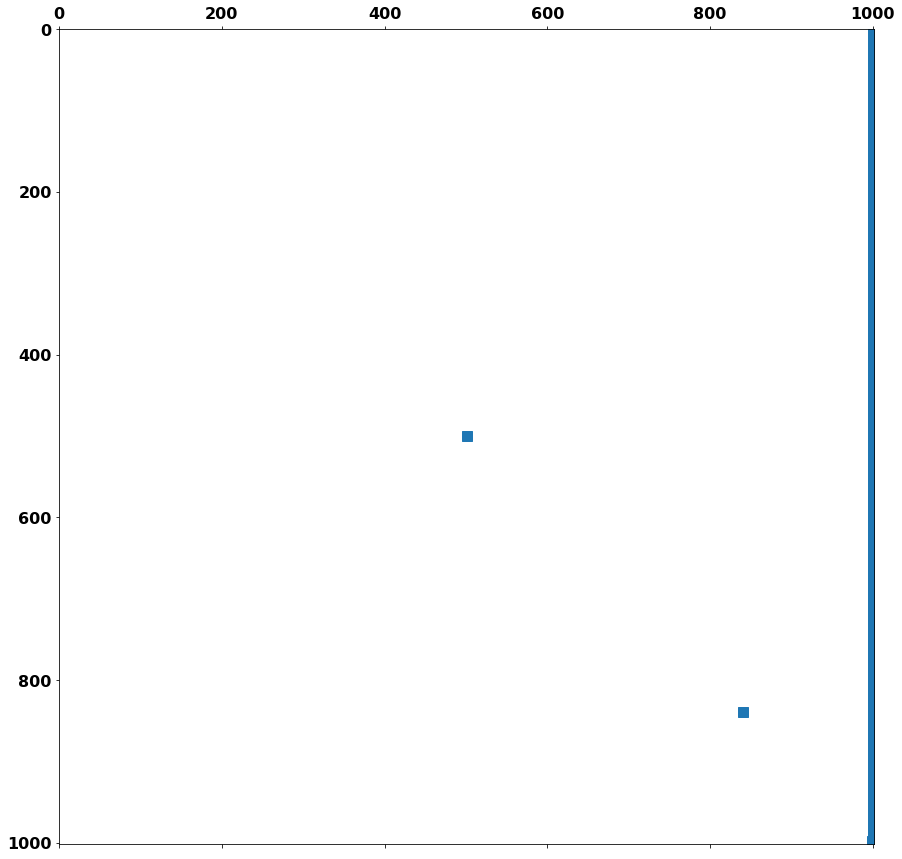

In [14]:
#plt.spy(T, markersize=4, figsize=(15,20))

fig, ax = plt.subplots(1, figsize=(15,15))
ax.spy(T)

In [ ]:
from scipy.sparse.linalg import eigs
w, v = eigs(T)
print(w)

In [ ]:
for m in mdim_mesh.values():
    print(m)